## Import Package

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import callbacks

## Prepare Train, Validation and Test Dataset

In [4]:
x_df = pd.read_csv("data/ACN.csv")
y_df = pd.read_csv("data/TSM.csv")

x_y_df = pd.merge(left=x_df, right=y_df, how="inner", on="Date")

In [3]:
x_y_df = x_y_df.iloc[4000:]

In [4]:
x_y_df.reset_index(inplace=True)

In [5]:
x_y_df

,Date,Open_x,High_x,Low_x,Close_x,Volume_x,Dividends_x,Stock Splits_x,Open_y,High_y,Low_y,Close_y,Volume_y,Dividends_y,Stock Splits_y
0,2001-07-19,11.234038,11.375393,11.159640,11.286116,34994300,0.0,0,5.273693,5.350124,5.273693,5.350124,4410910,0.0,0.0
1,2001-07-20,11.196839,11.196839,11.010845,11.167080,9238500,0.0,0,5.222741,5.222741,5.077160,5.117195,4079558,0.0,0.0
2,2001-07-23,11.159637,11.167077,10.824848,11.159637,7501000,0.0,0,5.117192,5.117192,4.876983,4.876983,4460811,0.0,0.0
3,2001-07-24,11.122439,11.137319,10.936445,11.055481,3537300,0.0,0,4.891543,4.902461,4.785996,4.789635,3598501,0.0,0.0
4,2001-07-25,10.936445,11.122439,10.899246,11.122439,4208100,0.0,0,4.876984,4.964333,4.822391,4.957054,4754038,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,2021-07-28,320.850006,321.000000,316.119995,316.309998,2006300,0.0,0,113.940002,115.510002,113.879997,115.070000,6819700,0.0,0.0
5038,2021-07-29,317.820007,319.140015,316.130005,318.350006,1863800,0.0,0,116.000000,117.110001,115.610001,116.150002,7162000,0.0,0.0
5039,2021-07-30,317.709991,319.179993,316.899994,317.679993,2305400,0.0,0,115.500000,117.419998,115.190002,116.639999,6481500,0.0,0.0
5040,2021-08-02,319.269989,319.489990,315.500000,316.079987,1507200,0.0,0,117.500000,118.379997,116.660004,116.860001,6023000,0.0,0.0


In [6]:
x_arr = x_y_df["Close_x"]
y_arr = x_y_df["Close_y"]
spread_arr = x_arr / y_arr

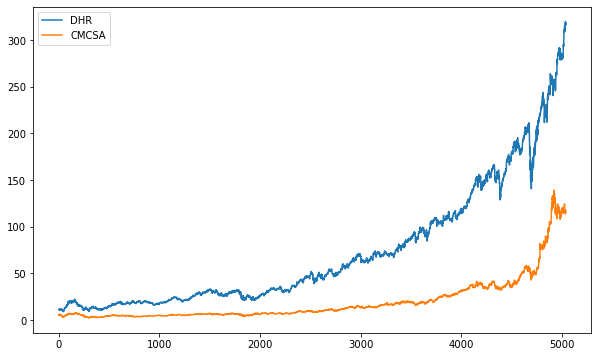

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(x_arr, label="DHR")
plt.plot(y_arr, label="CMCSA")
# plt.plot(spread_arr, label="Spread")
plt.legend()

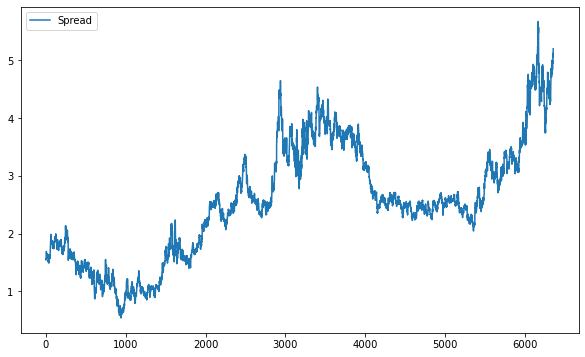

In [8]:
plt.figure(figsize=(10, 6))
# plt.plot(x_arr, label="ADBE")
# plt.plot(y_arr, label="MSFT")
plt.plot(spread_arr, label="Spread")
plt.legend()

In [9]:
spread_delta = []

for idx in range(1, len(spread_arr)):
    spread_delta.append(((spread_arr[idx] - spread_arr[idx-1]) / spread_arr[idx-1])*100)

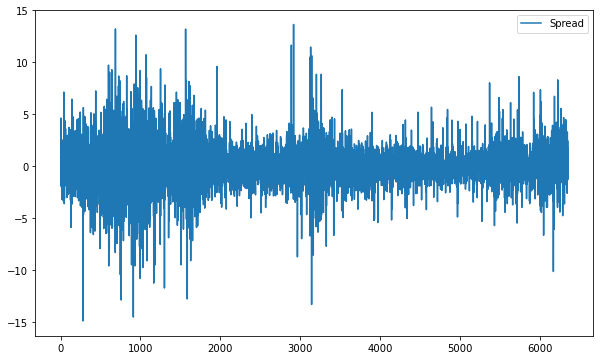

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(spread_delta, label="Spread")
plt.legend()

In [11]:
spread_delta = np.array(spread_delta)

In [12]:
df = pd.DataFrame(spread_delta, columns=["spread_delta"])

In [13]:
df.describe()

,spread_delta
count,6357.000000
mean,0.042698
std,2.171266
min,-14.868768
25%,-0.992660
50%,0.018134
75%,1.061830
max,13.643682


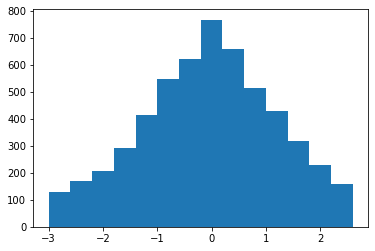

In [14]:
arr = plt.hist(spread_delta, bins=np.arange(-3, 3, 0.4))[0]

In [15]:
arr.sum()

5449.0

In [16]:
dataset_x = []
dataset_y = []

In [17]:
HISTORY_WINDOW_SIZE = 180

In [18]:
for idx in range(HISTORY_WINDOW_SIZE, len(x_arr)):

    sample_x = []
    
    x = np.array(x_arr[idx-HISTORY_WINDOW_SIZE:idx])
    y = np.array(y_arr[idx-HISTORY_WINDOW_SIZE:idx])
    x_y = np.concatenate((x, y))
    x_y_mu = np.mean(x_y)
    x_y_std = np.std(x_y)

    x = (x - x_y_mu) / x_y_std
    y = (y - x_y_mu) / x_y_std

    sample_x.append(x)
    sample_x.append(y)
    
    sample_x = np.array(sample_x)
    sample_x = np.transpose(sample_x)

    spread_delta = ((spread_arr[idx] - spread_arr[idx-1]) / spread_arr[idx-1]) * 100

    if spread_delta >= 3.0:
        sample_y = 0
    elif spread_delta < 3.0 and spread_delta >= 2.6:
        sample_y = 1
    elif spread_delta < 2.6 and spread_delta >= 2.2:
        sample_y = 2
    elif spread_delta < 2.2 and spread_delta >= 1.8:
        sample_y = 3
    elif spread_delta < 1.8 and spread_delta >= 1.4:
        sample_y = 4
    elif spread_delta < 1.4 and spread_delta >= 1.0:
        sample_y = 5
    elif spread_delta < 1.0 and spread_delta >= 0.6:
        sample_y = 6
    elif spread_delta < 0.6 and spread_delta >= 0.2:
        sample_y = 7
    elif spread_delta < 0.2 and spread_delta >= -0.2:
        sample_y = 8
    elif spread_delta < -0.2 and spread_delta >= -0.6:
        sample_y = 9
    elif spread_delta < -0.6 and spread_delta >= -1.0:
        sample_y = 10
    elif spread_delta < -1.0 and spread_delta >= -1.4:
        sample_y = 11
    elif spread_delta < -1.4 and spread_delta >= -1.8:
        sample_y = 12
    elif spread_delta < -1.8 and spread_delta >= -2.2:
        sample_y = 13
    elif spread_delta < -2.2 and spread_delta >= -2.6:
        sample_y = 14
    elif spread_delta < -2.6 and spread_delta >= -3.0:
        sample_y = 15
    else:
        sample_y = 16

    
    dataset_x.append(np.array(sample_x))
    dataset_y.append(sample_y)

In [19]:
dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

In [20]:
dataset_x.shape

(6178, 180, 2)

In [21]:
dataset_y.shape

(6178,)

In [22]:
dataset_y = utils.to_categorical(dataset_y, num_classes=17)

In [23]:
dataset_y.shape

(6178, 17)

In [24]:
dataset_x, dataset_y = sklearn.utils.shuffle(dataset_x, dataset_y)

In [25]:
count = np.zeros(17)
for arr in dataset_y:
    count[np.argmax(arr)] += 1

In [26]:
count

array([411., 106., 151., 223., 308., 423., 498., 647., 744., 601., 530.,
       405., 283., 200., 162., 121., 365.])

## Build Model

In [27]:
inputs = layers.Input(shape=(HISTORY_WINDOW_SIZE, 2))
x = layers.Conv1D(filters=256, kernel_size=14, activation="relu")(inputs)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=256, kernel_size=10, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=256, kernel_size=7, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=128, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(17, activation="softmax")(x)

In [ ]:
model = models.Model(
    inputs=inputs,
    outputs=outputs
)

In [28]:
model = models.load_model("best_model.hdf5")

In [36]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.00015), loss="categorical_crossentropy", metrics=["acc"])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 167, 256)          7424      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 83, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 74, 256)           655616    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 256)           459008    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 256)           0     

## Split Dataset

In [ ]:
train_ratio = 0.8

x_train = dataset_x[:int(len(dataset_x) * train_ratio)]
y_train = dataset_y[:int(len(dataset_x) * train_ratio)]

x_test = dataset_x[int(len(dataset_x) * train_ratio):]
y_test = dataset_y[int(len(dataset_x) * train_ratio):]

In [ ]:
validation_ratio = 0.1

x_validation = x_train[:int(len(x_train) * validation_ratio)]
y_validation = y_train[:int(len(x_train) * validation_ratio)]

x_train_ = x_train[int(len(x_train) * validation_ratio):]
y_train_ = y_train[int(len(x_train) * validation_ratio):]

## Train Model

In [37]:
check_point = callbacks.ModelCheckpoint(
    "best_model.hdf5", 
    monitor="loss", 
    verbose=1, 
    save_best_only=True,
    mode="auto",
    period=1
)

history = model.fit(
    x=dataset_x,
    y=dataset_y,
    batch_size=32,
    epochs=1000,
    #validation_data=(x_validation, y_validation),
    callbacks=[check_point]
)

Epoch 1/1000
194/194 [==============================] - 7s 32ms/step - loss: 0.3712 - acc: 0.8775

Epoch 00001: loss improved from inf to 0.35553, saving model to best_model.hdf5
Epoch 2/1000
194/194 [==============================] - 6s 33ms/step - loss: 0.3572 - acc: 0.8882

Epoch 00002: loss improved from 0.35553 to 0.35540, saving model to best_model.hdf5
Epoch 3/1000
194/194 [==============================] - 6s 33ms/step - loss: 0.3485 - acc: 0.8902

Epoch 00003: loss did not improve from 0.35540
Epoch 4/1000
194/194 [==============================] - 7s 34ms/step - loss: 0.3515 - acc: 0.8883

Epoch 00004: loss improved from 0.35540 to 0.35533, saving model to best_model.hdf5
Epoch 5/1000
194/194 [==============================] - 6s 33ms/step - loss: 0.3565 - acc: 0.8868

Epoch 00005: loss improved from 0.35533 to 0.35525, saving model to best_model.hdf5
Epoch 6/1000
194/194 [==============================] - 6s 33ms/step - loss: 0.3526 - acc: 0.8890

Epoch 00006: loss improved 

In [ ]:
plt.plot(history.history["acc"], label="Train Acc")
plt.plot(history.history["loss"], label="Train Loss")